In [30]:
%matplotlib notebook
import matplotlib
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate,fftpack
import csv

In [32]:
header = pd.read_csv('../datasets/slipperData/Alice.csv', nrows=1, header=None)
header = header.values[0]

In [33]:
#alice = pd.read_csv('Project/slipperData/Alice.csv', nrows=5000,skiprows=400,names=header)
alice = pd.read_csv('../datasets/slipperData/Alice.csv', skiprows=1, names=header)

In [34]:
ts = alice['Timestamp'].values
ts_orig = ts - min(ts)
axis = [alice['Axis' + str(i+1)].values for i in range(3)]

In [35]:

fs = 33
ps = 1/fs
n = np.int16(8192)
freq = np.linspace(0, fs/2, num=int(n//2))
ts_new =  np.arange(min(ts_orig), max(ts_orig), ps)
axis_interpolant = [interpolate.interp1d(ts_orig, axis[i]) for i in range(3) ]
axis_new = [axis_interpolant[i](ts_new) for i in range(3) ]

In [36]:
axis_new = [axis_new[i] - np.mean(axis_new[i]) for i in range(3)]

<IPython.core.display.Javascript object>


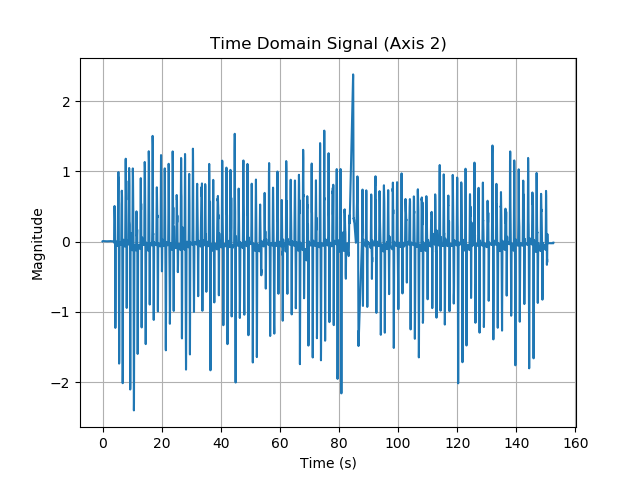

In [37]:
#corner_freq = 15
#b, a = signal.ellip(10, 0.01, 100, 2 * corner_freq / fs)
#axis_lpf = [signal.filtfilt(b, a, axis_new[i]) for i in range(3)]

filter_length = 5
win = np.ones(filter_length)
i=1
axis_lpf = [signal.convolve(axis_new[i], win, mode='same') / filter_length for i in range(3)]

plt.figure()
plt.plot(ts_new, axis_lpf[0])
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.title('Time Domain Signal (Axis ' + str(i + 1) + ')')
plt.grid()

<IPython.core.display.Javascript object>


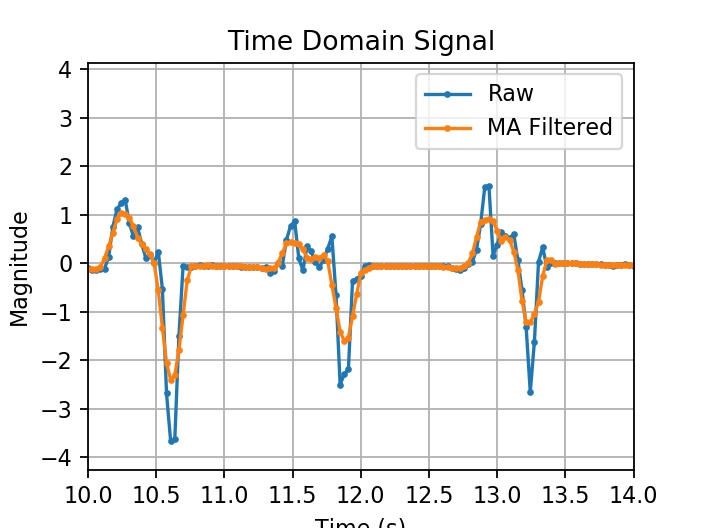

<IPython.core.display.Javascript object>


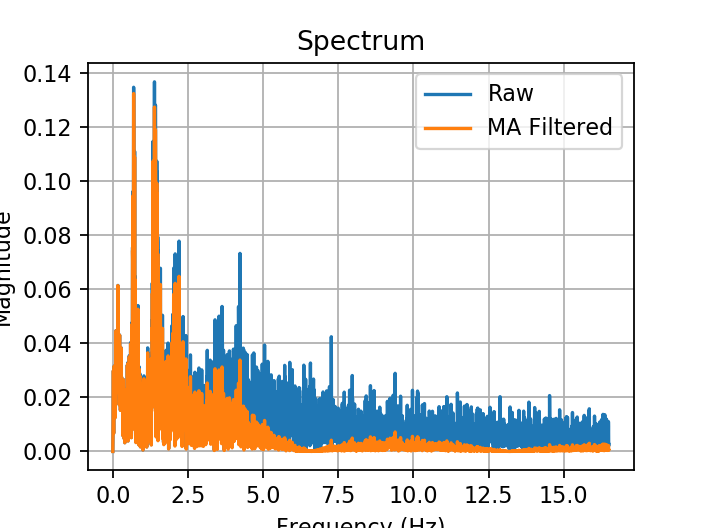

In [38]:
plt.figure(figsize=(4*1.1, 3*1.1), dpi=160)
h1, = plt.plot(ts_new, axis_new[0], 'o-', ms=2, label='Raw')
h2, = plt.plot(ts_new, axis_lpf[0], 'o-', ms=2, label='MA Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.title('Time Domain Signal')
plt.grid()
plt.xlim(10,14)
plt.legend(handles=[h1, h2])

req = np.linspace(0, fs / 2, num=int(n // 2))
plt.figure(figsize=(4*1.1, 3*1.1), dpi=160)
spectrum_orig = fftpack.fft(axis_new[0], n=n) / len(axis_new[0])
spectrum_orig_ss = spectrum_orig[0:n // 2]
spectrum_orig_ss[2:] = 2 * spectrum_orig_ss[2:]
h1, = plt.plot(freq, np.abs(spectrum_orig[0:n // 2]), label='Raw')
spectrum = fftpack.fft(axis_lpf[0], n=n) / len(axis_lpf[0])
spectrum_ss = spectrum[0:n // 2]
spectrum_ss[2:] = 2 * spectrum_ss[2:]
freq = np.linspace(0, fs / 2, num=int(n // 2))
h2, = plt.plot(freq, np.abs(spectrum[0:n // 2]), label='MA Filtered')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.legend(handles=[h1, h2])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


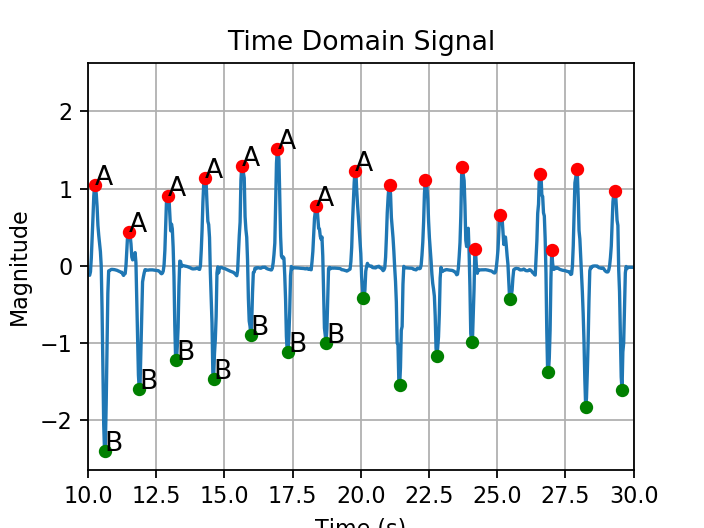

<function matplotlib.pyplot.show>

In [39]:
search_order = 5
peaks_idx = np.array(signal.argrelmax(axis_lpf[0], order=search_order))
valleys_idx = np.array(signal.argrelmin(axis_lpf[0], order=search_order))

peaks_t = ts_new[peaks_idx]
valleys_t = ts_new[valleys_idx]
peaks = axis_lpf[0][peaks_idx]
valleys = axis_lpf[0][valleys_idx]

peaks_filt = np.nonzero(np.logical_and(peaks > 0.2, peaks < 4))
valleys_filt = np.nonzero(np.logical_and(valleys < -0.2, valleys > -4))

peaks_idx = peaks_idx[peaks_filt]
valleys_idx = valleys_idx[valleys_filt]
peaks_t = ts_new[peaks_idx]
valleys_t = ts_new[valleys_idx]
peaks = axis_lpf[0][peaks_idx]
valleys = axis_lpf[0][valleys_idx]


plt.figure(figsize=(4*1.1, 3*1.1), dpi=160)
plt.plot(ts_new, axis_lpf[0])
plt.plot(peaks_t, peaks, 'ro',ms=5)
plt.plot(valleys_t, valleys, 'go',ms=5)
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
#plt.title('Time Domain Signal (Axis ' + str(i + 1) + ')')
plt.title('Time Domain Signal')
for i in range(5,13):
    plt.text(peaks_t[i], peaks[i], "A", fontsize=12)

for i in range(5,12):
    plt.text(valleys_t[i], valleys[i], "B", fontsize=12)
    
plt.grid()
plt.xlim(10,30)
plt.show

In [8]:
#取 Time > 10 的資料點  從第331個資料開始是大於10的
ts_new_inrange = (ts_new[ts_new>10])
axis_lpf_inrange = axis_lpf[0][331:]

data_inrange = pd.DataFrame()
data_inrange['0'] = ts_new_inrange
data_inrange['1'] = axis_lpf_inrange



NameError: name 'ts_new' is not defined

In [9]:
#第五個peak、Valley 在取值範圍中 
np.where(peaks_t>10)

NameError: name 'np' is not defined

In [10]:
##########################

In [11]:
for i in range(50): 
    a = np.where(data_inrange['1'] == peaks[5+i])[0][0]
    b = np.where(data_inrange['1'] == valleys[5+i])[0][0]
    c = np.where(data_inrange['1'] == peaks[5+(i+1)])[0][0]

    if (((b-a)>0) & ((b-c)>0)): #表示異常
        peaks = np.delete(peaks,5+i )
print (len(peaks))        
print (len(valleys))

NameError: name 'np' is not defined

In [12]:
def cut(data,peaks,valleys):
    #波異常偵測 
    for i in range(50): 
        a = np.where(data_inrange['1'] == peaks[5+i])[0][0]
        b = np.where(data_inrange['1'] == valleys[5+i])[0][0]
        c = np.where(data_inrange['1'] == peaks[6+i])[0][0]
        if ((b-a)>0 & (b-c)>0): #表示異常
            np.delete(peaks,5+i-5+1 )
    
    data_inrange = data
    peaks = peaks
    valleys = valleys
    wave_length = []
    ts_cut = 0
    for i in range(50): #切50個波
        a = np.where(data_inrange['1'] == peaks[5+i])[0][0]
        b = np.where(data_inrange['1'] == valleys[5+i])[0][0]
        c = np.where(data_inrange['1'] == peaks[6+i])[0][0]
        
        ts_cute =(data_inrange['0'][b]+data_inrange['0'][c])/2
        ts_new_inrange_ =data_inrange['0'][(data_inrange['0']<=ts_cute)& (data_inrange['0']>= ts_cut)]
        ts_cut = ts_cute
        wave_length.append(len(ts_new_inrange_))
        
    return  wave_length 

In [13]:
#以第一步為主做伸縮 (N1 取4個點 ，N2取4個點 , N3取4個點)

In [14]:
def extend(number,data,wave_length,peaks,valleys):
    number = number
    data_inrange = data
    wave_length = wave_length
    peaks = peaks
    valleys = valleys
    start_index = 0
    stepN1 = 0
    stepN2 = 0
    stepN3 = 0
    N1 = []
    N2 = []
    N3 = []
    N_extended = [] 
    end_index = 33
    for a in range(number):
        if (a>0):
            start_index = start_index+wave_length[a-1]
    if((number-1)>0):
        end_index = start_index+wave_length[number-1]-1
        
    peak = np.where(data_inrange['1'] == peaks[5+number-1])[0][0] ##波峰
    
    valley = np.where(data_inrange['1'] == valleys[5+number-1])[0][0] ##波谷
    
    stepN1 = int((peak - start_index)/4)
    if((peak - start_index)<0):
        peak = peak+1
        print ('異常步伐',a)
        
        return 0
    if (stepN1==0):
        stepN1 = stepN1+1
    
        
    j =0
    for a in range(0,(peak - start_index)-1,stepN1):
        N1 = np.append(N1,data_inrange[start_index+j:start_index+j+1]['1'])
        j = j+stepN1
        
        if(len(N1)>=4): #防止線段取了超過4個點
            break 
        
    N1 = np.append(N1, data_inrange[peak:peak+1]['1'])  #N1段包含peak
        
        
    stepN2 = int((valley - peak)/4)
    if (stepN2==0):
        stepN2 = stepN2+1
          
    for a in range(0,(valley - (peak+1)+1)-1,stepN2):
        N2 = np.append(N2,data_inrange[peak+j:peak+j+1]['1'])
        j = j+stepN2
        
        if(len(N2)>=4): #防止線段取了超過4個點
            break
    N2 = np.append(N2, data_inrange[valley:valley+1]['1'])  #N2段包含Valley
    
    stepN3 = int((end_index - valley)/4)
    if (stepN3==0):
        stepN3 = stepN3+1
      
    for a in range(0,(end_index - (valley+1)+1)-1,stepN3):
        N3 = np.append(N3,data_inrange[valley+j:valley+j+1]['1'])
        j = j+stepN3
        
        if(len(N3)>=4): #防止線段取了超過4個點
            break 
    N3 = np.append(N3, data_inrange[end_index:end_index+1]['1'])  #N2段包含Valley
    
    N_extended = np.append(N_extended,N1)
    N_extended = np.append(N_extended,N2)
    N_extended = np.append(N_extended,N3)
    
    return N_extended

In [15]:
N= []
number_waves =8  #訓練集要放入1~~N個波

In [16]:
for i in range(1,number_waves+1):
    N.append(extend(i,data_inrange,cut(data_inrange,peaks,valleys),peaks,valleys))
   

NameError: name 'data_inrange' is not defined

In [17]:
#########GAN STRUCTURE

In [18]:
#超參數設置 
import torch
import torch.nn as nn
from torch.autograd import Variable
import random


BATCH_SIZE = 15
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_Try = 5 # Work 隨機嘗試了五個靈感
Try_Components = 15

ModuleNotFoundError: No module named 'torch'

In [19]:
#真實資料產生方式
def generator_workers():
    data_true = random.choice (N)
    a = []
    for i in range (15):
            a.append(data_true)
    a = np.array(a)        
    workings = torch.from_numpy(a).float()   
    return Variable (workings)

In [20]:
# Generator 設計  5-128-15 激勵函數: RELU
G = nn.Sequential(
    nn.Linear(N_Try,128),            # random Try (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, Try_Components),     # making a Try from these random ideas
)   

NameError: name 'nn' is not defined

In [21]:
# Discriminator 設計  15-128-1 激勵函數: RELU
D = nn.Sequential(                      # Discriminator
    nn.Linear(Try_Components, 128),     # receive a work either from the true data or a newbie like G or fake point
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the  work is made by true data
)

NameError: name 'nn' is not defined

In [22]:
#優化
opt_D  = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G  = torch.optim.Adam(G.parameters(), lr=LR_G)


NameError: name 'torch' is not defined

In [23]:
#訓練

for step in range (10000):
    True_working = generator_workers()  #生成該次訓練的真實資料
    G_try = Variable(torch.randn(BATCH_SIZE, N_Try)) # G嘗試
    G_working = G(G_try) # G嘗試結果
    
  
    
    prob_True0 = D(True_working) #多少比例的真實資料是D判斷來自真實資料
    prob_True1 = D(G_working) #創作的資料多少比例是D判斷來自真實資料
    
    D_loss = -torch.mean(torch.log(prob_True0)+torch.log(1-prob_True1))
    G_loss = torch.mean(torch.log(1 - prob_True1))
    
    opt_D.zero_grad()
    D_loss.backward(retain_variables=True)      # retain_variables 这个参数是为了再次使用计算图纸
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    

NameError: name 'random' is not defined

In [24]:
##input 第N步 測試 extend(i,data_inrange,cut(data_inrange,peaks,valleys),peaks,valleys)
def error(a,b):
    return (a-b)/b

In [25]:
error_value = []
for i in range(1,12):
    a = []
    for j in range(15):
        a.append(extend(i,data_inrange,cut(data_inrange,peaks,valleys),peaks,valleys))
    np_a = np.array(a)
    workings1 = torch.from_numpy(np_a).float() 
    d = D(Variable(workings1))
    error_value.append(abs(error(d,0.50).data[0][0]))
        

NameError: name 'data_inrange' is not defined

In [26]:
#Generator 測試

G_try = Variable(torch.randn(BATCH_SIZE, N_Try)) # G嘗試
G_working = G(G_try)
sum = 0
for i in range (15):
    sum = sum +D(G_working)[0][0]
    
average = sum/15
average = average.data[0]

error(average,0.5)

NameError: name 'Variable' is not defined

In [27]:
number_of_waves = np.arange(0,11)

NameError: name 'np' is not defined

In [28]:
plt.figure(figsize=(4*1.1, 3*1.1), dpi=160)
plt.plot(number_of_waves+1, error_value)

plt.ylim(0,0.8)

NameError: name 'plt' is not defined

In [29]:
plt.show()

NameError: name 'plt' is not defined

#第五個peak在x index 7的位置
np.where(data_inrange['1'] == peaks[5])
a = np.where(data_inrange['1'] == valleys[5])
np.where(data_inrange['1'] == peaks[6])

#第1 2個波的斷點計算(index 19 & 48 的中點) ts_cut =(data_inrange['0'][a[0][0]]+data_inrange['0'][48])/2 ts_new_inrange_first =data_inrange['0'][data_inrange['0']<=ts_cut]

#第一個波為第0~33個點 (34) 包含 peak在index 7 valley在index 19
#ts_new_inrange_first

np.where(data_inrange['1'] == valleys[6])

np.where(data_inrange['1'] == peaks[7])

#第2 3個波的斷點計算(index 61 & 96 的中點)
ts_cut2 =(data_inrange['0'][61]+data_inrange['0'][96])/2
ts_new_inrange_second = data_inrange['0'][(data_inrange['0']<=ts_cut2)& (data_inrange['0']>= ts_cut)]

#第二個波為第34~78個點 (45) 包含 peak在index 48 valley在index 61
#ts_new_inrange_second

np.where(data_inrange['1'] == valleys[7])
np.where(data_inrange['1'] == peaks[8])

#第3 4個波的斷點計算(index 106 & 140 的中點) ts_cut3 =(data_inrange['0'][106]+data_inrange['0'][140])/2 ts_new_inrange_third = data_inrange['0'][(data_inrange['0']<=ts_cut3)& (data_inrange['0']>= ts_cut2)]

#第三個波為第79~123個點 (45) 包含 peak在index 96 valley在index 106
#ts_new_inrange_third

#第一個波伸縮 N1 = [] N1 = np.append(N1,data_inrange[0:1]['1']) N1 = np.append(N1,data_inrange[2:3]['1']) N1 = np.append(N1,data_inrange[4:5]['1']) N1 = np.append(N1,data_inrange[6:7]['1']) N1 = np.append(N1, data_inrange[7:8]['1']) #N1段包含peak
N2 = [] N2 = np.append(N2,data_inrange[8:9]['1']) N2 = np.append(N2,data_inrange[11:12]['1']) N2 = np.append(N2,data_inrange[14:15]['1']) N2 = np.append(N2,data_inrange[17:18]['1']) N2 = np.append(N2,data_inrange[19:20]['1']) #N2段包含vellay
N3 = [] N3 = np.append(N3,data_inrange[20:21]['1']) N3 = np.append(N3,data_inrange[23:24]['1']) N3 = np.append(N3,data_inrange[26:27]['1']) N3 = np.append(N3,data_inrange[29:30]['1']) N3 = np.append(N3,data_inrange[33:34]['1'])
N_first = [] N_first = np.append(N_first,N1) N_first = np.append(N_first,N2) N_first = np.append(N_first,N3) #第一個波伸縮完成

#第二個波伸縮 N1 = [] N1 N1 = np.append(N1,data_inrange[34:35]['1']) N1 = np.append(N1,data_inrange[38:39]['1']) N1 = np.append(N1,data_inrange[42:43]['1']) N1 = np.append(N1,data_inrange[46:47]['1']) N1 = np.append(N1,data_inrange[48:49]['1']) #N1段包含peak
N2 = [] N2 = np.append(N2,data_inrange[49:50]['1']) N2 = np.append(N2,data_inrange[52:53]['1']) N2 = np.append(N2,data_inrange[55:56]['1']) N2 = np.append(N2,data_inrange[58:59]['1']) N2 = np.append(N2,data_inrange[61:62]['1']) #N2段包含vellay
N3 = [] N3 = np.append(N3,data_inrange[62:63]['1']) N3 = np.append(N3,data_inrange[66:67]['1']) N3 = np.append(N3,data_inrange[70:71]['1']) N3 = np.append(N3,data_inrange[74:75]['1']) N3 = np.append(N3,data_inrange[78:79]['1'])
N_second = [] N_second = np.append(N_second,N1) N_second = np.append(N_second,N2) N_second = np.append(N_second,N3) #第二個波伸縮完成

#第三個波伸縮 N1 = [] N1 N1 = np.append(N1,data_inrange[79:80]['1']) N1 = np.append(N1,data_inrange[83:84]['1']) N1 = np.append(N1,data_inrange[87:88]['1']) N1 = np.append(N1,data_inrange[91:92]['1']) N1 = np.append(N1,data_inrange[96:97]['1']) #N1段包含peak
N2 = [] N2 = np.append(N2,data_inrange[97:98]['1']) N2 = np.append(N2,data_inrange[99:100]['1']) N2 = np.append(N2,data_inrange[101:102]['1']) N2 = np.append(N2,data_inrange[103:104]['1']) N2 = np.append(N2,data_inrange[105:106]['1']) #N2段包含vellay
N3 = [] N3 = np.append(N3,data_inrange[107:108]['1']) N3 = np.append(N3,data_inrange[111:112]['1']) N3 = np.append(N3,data_inrange[115:116]['1']) N3 = np.append(N3,data_inrange[119:120]['1']) N3 = np.append(N3,data_inrange[123:124]['1'])
N_third = [] N_third = np.append(N_third,N1) N_third = np.append(N_third,N2) N_third = np.append(N_third,N3) #第二個波伸縮完成